[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [7]:
!nvidia-smi

Thu Jun 26 11:38:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 77.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [5]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-06-29 15:24:04--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-06-29 15:24:04 (93.9 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"/content/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12s.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [8]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="eexYE5XwI43N1ZmSzuCL")
project = rf.workspace("object-detection-aowty").project("accident-detection-qgglm-litlf")
version = project.version(4)
dataset = version.download("yolov12")


AttributeError: module 'pillow_heif' has no attribute 'register_avif_opener'

In [6]:
!ls {dataset.location}

data.yaml  README.roboflow.txt	test  train  valid


In [11]:
!ls /content


Accident-detection-4  augmented  dog.jpeg  sample_data	yolov12s.pt


In [12]:
image_dir = "/content/accident-detection-qgglm-4/train/images"
label_dir = "/content/accident-detection-qgglm-4/train/labels"
output_image_dir = "/content/augmented/train/images"
output_label_dir = "/content/augmented/train/labels"


In [26]:
original_images_dir = "/content/Accident-detection-4/train/images"
original_image_files = [f for f in os.listdir(original_images_dir) if f.endswith('.jpg')]
print(f"Original images: {len(original_image_files)}")


Original images: 17376


In [13]:
!pip install albumentations opencv-python-headless


In [17]:
import os

image_dir = "/content/Accident-detection-4/train/images"  # Replace if needed

print("Files in folder:")
print(os.listdir(image_dir)[:10])  # show first 10 entries


Files in folder:
['severV16_jpg.rf.9180f76d4ac14b0abaaf63cc625e24dd.jpg', 'Semi-RealisticVD-169_jpg.rf.be806b9c7b637a48799de795be5b19c1.jpg', 'test21_13_jpg.rf.38ee35c1fd9d82e616e9fae0cdcce14d.jpg', 'severityV4_72_jpg.rf.48e97a8823fc7076be7262d4c4f53488.jpg', 'accidentFrame2719_jpg.rf.29fbf75302910fc40008dc2aed184600.jpg', 'test17_7_jpg.rf.8efc6469aade7d8fbad69a58b740f4fb.jpg', 'severityV4_56_jpg.rf.ecae759c11dddc2c9b31806ecf2a3560.jpg', '1477548_082016-bayonnewreck_jpg.rf.0ec7550012bfb6a396ddc15a36806e2f.jpg', 'traffic_img1349_jpg.rf.a224b01e8db3b8c9f39c1b6d9dff22f4.jpg', '2-16_jpg.rf.9521b0b3c6ef393fa89dbd92ba368216.jpg']


In [18]:
from glob import glob

image_files = glob(os.path.join(image_dir, "*.*"))  # any file
image_files = [f for f in image_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"Total image files found: {len(image_files)}")


Total image files found: 17376


In [21]:
import os
import cv2
import albumentations as A
from glob import glob
import random

# ✅ Update this with your actual Roboflow dataset path
dataset_path = "/content/accident-detection-qgglm-4"  # <-- Replace if needed
image_dir = os.path.join(dataset_path, "/content/Accident-detection-4/train/images")
label_dir = os.path.join(dataset_path, "/content/Accident-detection-4/train/labels")

# ✅ Output directories for augmented data
output_image_dir = "/content/augmented/train/images"
output_label_dir = "/content/augmented/train/labels"
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

# ✅ Augmentation pipeline using Albumentations
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Blur(p=0.2),
    A.Rotate(limit=25, p=0.5),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# ✅ Load all image files regardless of extension
image_files = glob(os.path.join(image_dir, "*.*"))
image_files = [f for f in image_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"✅ Total image files found: {len(image_files)}")

if not image_files:
    raise FileNotFoundError(f"No images found in {image_dir}")

# ✅ Augmentation process
for img_path in image_files:
    filename = os.path.basename(img_path)
    label_path = os.path.join(label_dir, filename.rsplit('.', 1)[0] + ".txt")

    if not os.path.exists(label_path):
        print(f"⚠️ Skipping {filename} — label not found: {label_path}")
        continue

    image = cv2.imread(img_path)
    if image is None:
        print(f"⚠️ Skipping {filename} — unable to read image")
        continue

    h, w, _ = image.shape

    # Read label file
    with open(label_path, "r") as f:
        lines = f.read().strip().splitlines()

    if not lines:
        print(f"⚠️ Skipping {filename} — empty label file")
        continue

    bboxes = []
    class_labels = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            print(f"⚠️ Skipping invalid label line in {label_path}: {line}")
            continue
        cls, x, y, bw, bh = map(float, parts)
        class_labels.append(int(cls))
        bboxes.append([x, y, bw, bh])

    if not bboxes:
        print(f"⚠️ Skipping {filename} — no valid bounding boxes")
        continue

    # Generate 2 augmentations per image
    for i in range(2):
        try:
            augmented = augment(image=image, bboxes=bboxes, class_labels=class_labels)
            aug_img = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_classes = augmented['class_labels']

            aug_filename = f"{filename.rsplit('.', 1)[0]}_aug{i}.jpg"
            aug_img_path = os.path.join(output_image_dir, aug_filename)
            aug_label_path = os.path.join(output_label_dir, aug_filename.replace('.jpg', '.txt'))

            # Save augmented image
            cv2.imwrite(aug_img_path, aug_img)

            # Save augmented label
            with open(aug_label_path, "w") as f:
                for cls, bbox in zip(aug_classes, aug_bboxes):
                    f.write(f"{cls} {' '.join(map(str, bbox))}\n")

            print(f"✅ Augmented and saved: {aug_filename}")

        except Exception as e:
            print(f"❌ Error augmenting {filename}: {e}")


Streaming output truncated to the last 5000 lines.
✅ Augmented and saved: traffic_img879_jpg.rf.2433e18644b6cd9128a889063ce540d8_aug0.jpg
✅ Augmented and saved: traffic_img879_jpg.rf.2433e18644b6cd9128a889063ce540d8_aug1.jpg
✅ Augmented and saved: severity_V139_jpg.rf.e822c8675a77944912e86fbcb30aebd1_aug0.jpg
✅ Augmented and saved: severity_V139_jpg.rf.e822c8675a77944912e86fbcb30aebd1_aug1.jpg
✅ Augmented and saved: accidentFrame3419_jpg.rf.ed390c5c22930ceb4aef9c8c6bad1d41_aug0.jpg
✅ Augmented and saved: accidentFrame3419_jpg.rf.ed390c5c22930ceb4aef9c8c6bad1d41_aug1.jpg
✅ Augmented and saved: traffic_img539_jpg.rf.56f484573f3435d1c1487b5ca3663fd1_aug0.jpg
✅ Augmented and saved: traffic_img539_jpg.rf.56f484573f3435d1c1487b5ca3663fd1_aug1.jpg
✅ Augmented and saved: download-10_jpg.rf.8e4d86b128d4bbe77d1655cbebcc3803_aug0.jpg
✅ Augmented and saved: download-10_jpg.rf.8e4d86b128d4bbe77d1655cbebcc3803_aug1.jpg
✅ Augmented and saved: severityV3_6_jpeg_jpg.rf.000e0f910febab7f4e4c0c34b28e6842_

In [22]:
print("✅ Augmentation complete.")
print("Augmented images:", len(os.listdir(output_image_dir)))
print("Augmented labels:", len(os.listdir(output_label_dir)))


✅ Augmentation complete.
Augmented images: 34740
Augmented labels: 34740


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [23]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [24]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 7
names: ['Accident', 'NoAcciednt', 'car', 'mild', 'moderate', 'motor cycle', 'severe']

roboflow:
  workspace: object-detection-aowty
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [26]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=10)

New https://pypi.org/project/ultralytics/8.3.159 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/Accident-detection-4/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=F

100%|██████████| 755k/755k [00:00<00:00, 23.5MB/s]


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 85.5MB/s]


AMP: checks passed ✅


train: Scanning /content/Accident-detection-4/train/labels... 17376 images, 6 backgrounds, 0 corrupt: 100%|██████████| 17376/17376 [00:12<00:00, 1351.29it/s]


train: New cache created: /content/Accident-detection-4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Accident-detection-4/valid/labels... 4993 images, 1 backgrounds, 0 corrupt: 100%|██████████| 4993/4993 [00:08<00:00, 594.65it/s]


val: New cache created: /content/Accident-detection-4/valid/labels.cache
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      6.72G      2.477      3.888      3.418         16        640: 100%|██████████| 1086/1086 [09:52<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [01:05<00:00,  2.40it/s]


                   all       4993       6418     0.0706      0.116     0.0549     0.0213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      6.68G      1.804      2.325      2.358         15        640: 100%|██████████| 1086/1086 [09:42<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


                   all       4993       6418      0.568      0.165      0.138     0.0733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      6.66G      1.487      1.858      1.992         30        640: 100%|██████████| 1086/1086 [09:36<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


                   all       4993       6418      0.486        0.2      0.189      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      6.66G      1.312      1.573      1.802         20        640: 100%|██████████| 1086/1086 [09:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


                   all       4993       6418      0.647       0.22       0.23      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       6.7G       1.16      1.348       1.64         19        640: 100%|██████████| 1086/1086 [09:32<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


                   all       4993       6418       0.66      0.294      0.272      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      6.83G      1.067      1.193      1.546         31        640: 100%|██████████| 1086/1086 [09:32<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [01:02<00:00,  2.50it/s]


                   all       4993       6418      0.538      0.306      0.284      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      6.83G     0.9703      1.048      1.452         27        640: 100%|██████████| 1086/1086 [09:32<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [01:03<00:00,  2.49it/s]


                   all       4993       6418      0.691      0.323      0.311       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      6.83G     0.8976     0.9429      1.384         19        640: 100%|██████████| 1086/1086 [09:32<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [01:03<00:00,  2.49it/s]

                   all       4993       6418      0.694      0.322      0.324      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      6.83G     0.8327     0.8521      1.325         17        640: 100%|██████████| 1086/1086 [09:32<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [01:02<00:00,  2.51it/s]

                   all       4993       6418      0.721      0.356      0.333      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      6.83G     0.7694     0.7828      1.272         16        640: 100%|██████████| 1086/1086 [09:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


                   all       4993       6418      0.725      0.357       0.34      0.265

10 epochs completed in 1.783 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 18.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,076,917 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [01:04<00:00,  2.44it/s]


                   all       4993       6418      0.725      0.357      0.339      0.265
              Accident          1          1          1          0   0.000247   4.93e-05
            NoAcciednt        196       1095      0.419      0.496      0.377      0.178
                   car         60        312      0.165      0.147      0.114     0.0519
                  mild         18         21          1          0     0.0297     0.0174
              moderate       1180       1192      0.615      0.893       0.88       0.75
           motor cycle          3         15          1          0          0          0
                severe       3603       3782      0.874      0.961      0.975      0.857
Speed: 0.2ms preprocess, 8.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train2


## Evaluate fine-tuned YOLOv12 model

In [28]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls /content/runs/detect/train2

args.yaml					   results.png
confusion_matrix_normalized.png			   train_batch0.jpg
confusion_matrix.png				   train_batch1.jpg
events.out.tfevents.1750941461.a109402290e1.376.0  train_batch2.jpg
F1_curve.png					   val_batch0_labels.jpg
labels_correlogram.jpg				   val_batch0_pred.jpg
labels.jpg					   val_batch1_labels.jpg
P_curve.png					   val_batch1_pred.jpg
PR_curve.png					   val_batch2_labels.jpg
R_curve.png					   val_batch2_pred.jpg
results.csv					   weights


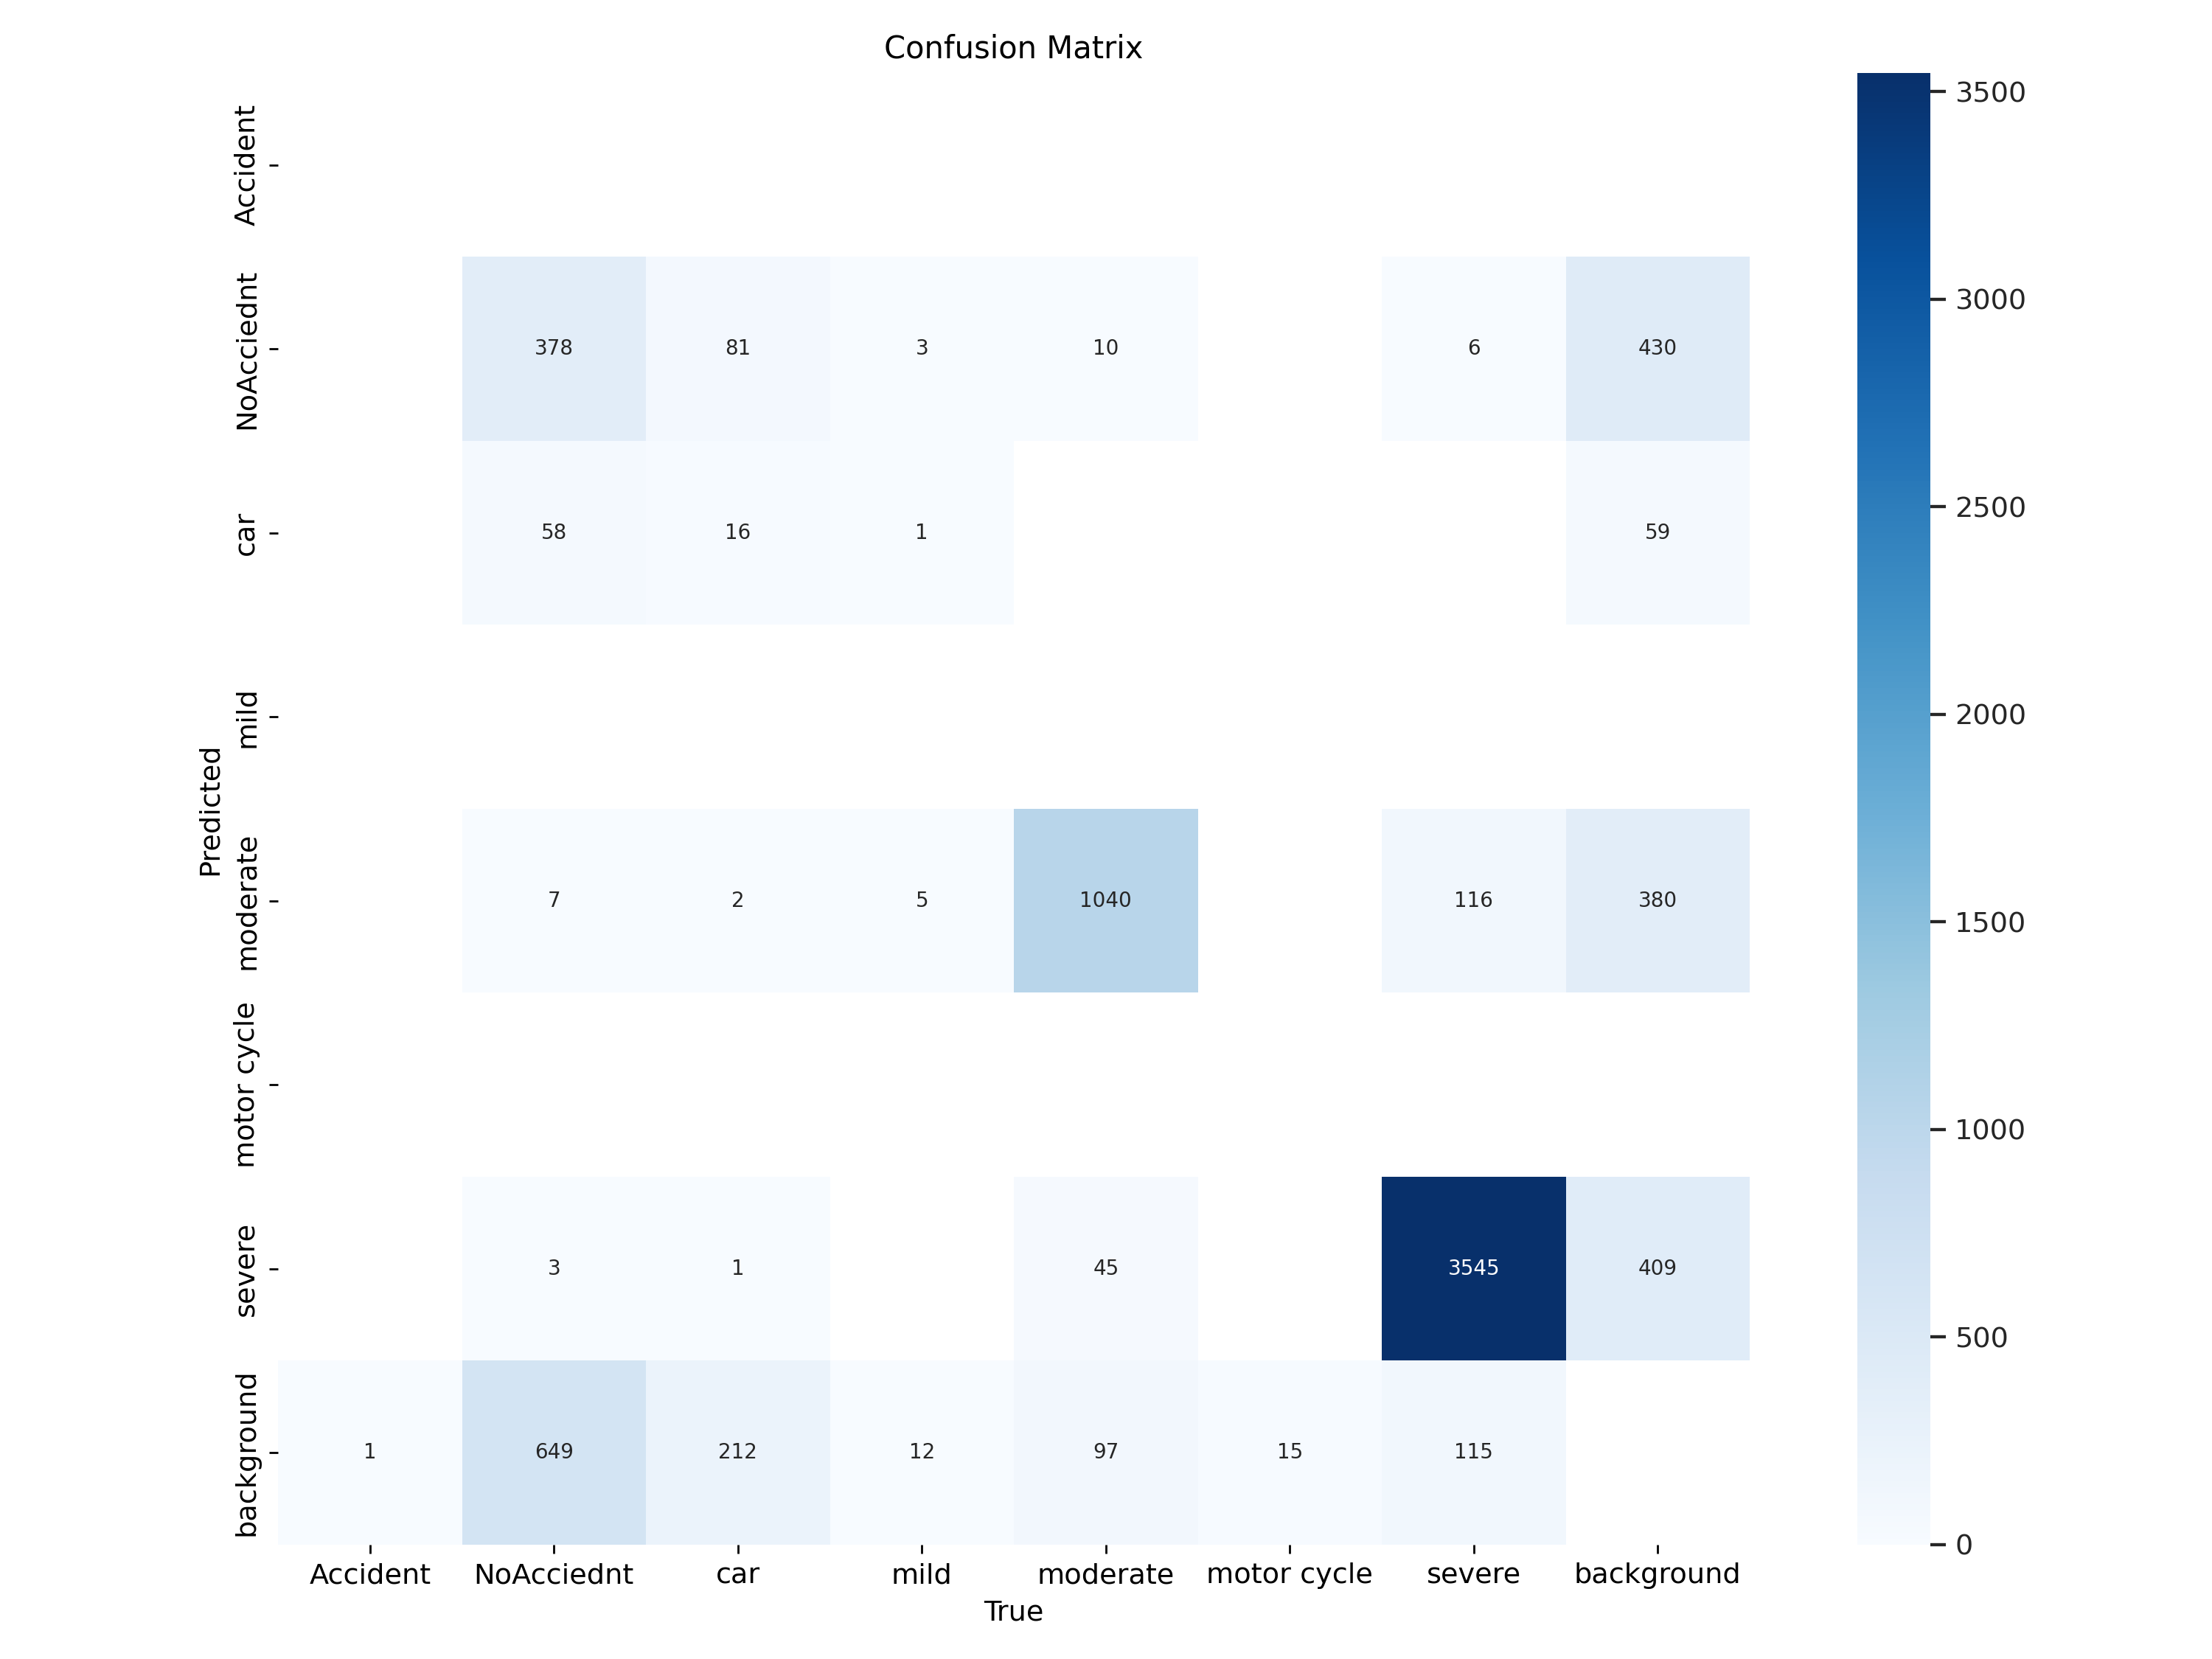

In [30]:
from IPython.display import Image

Image(filename=f'/content/runs/detect/train2/confusion_matrix.png', width=1000)

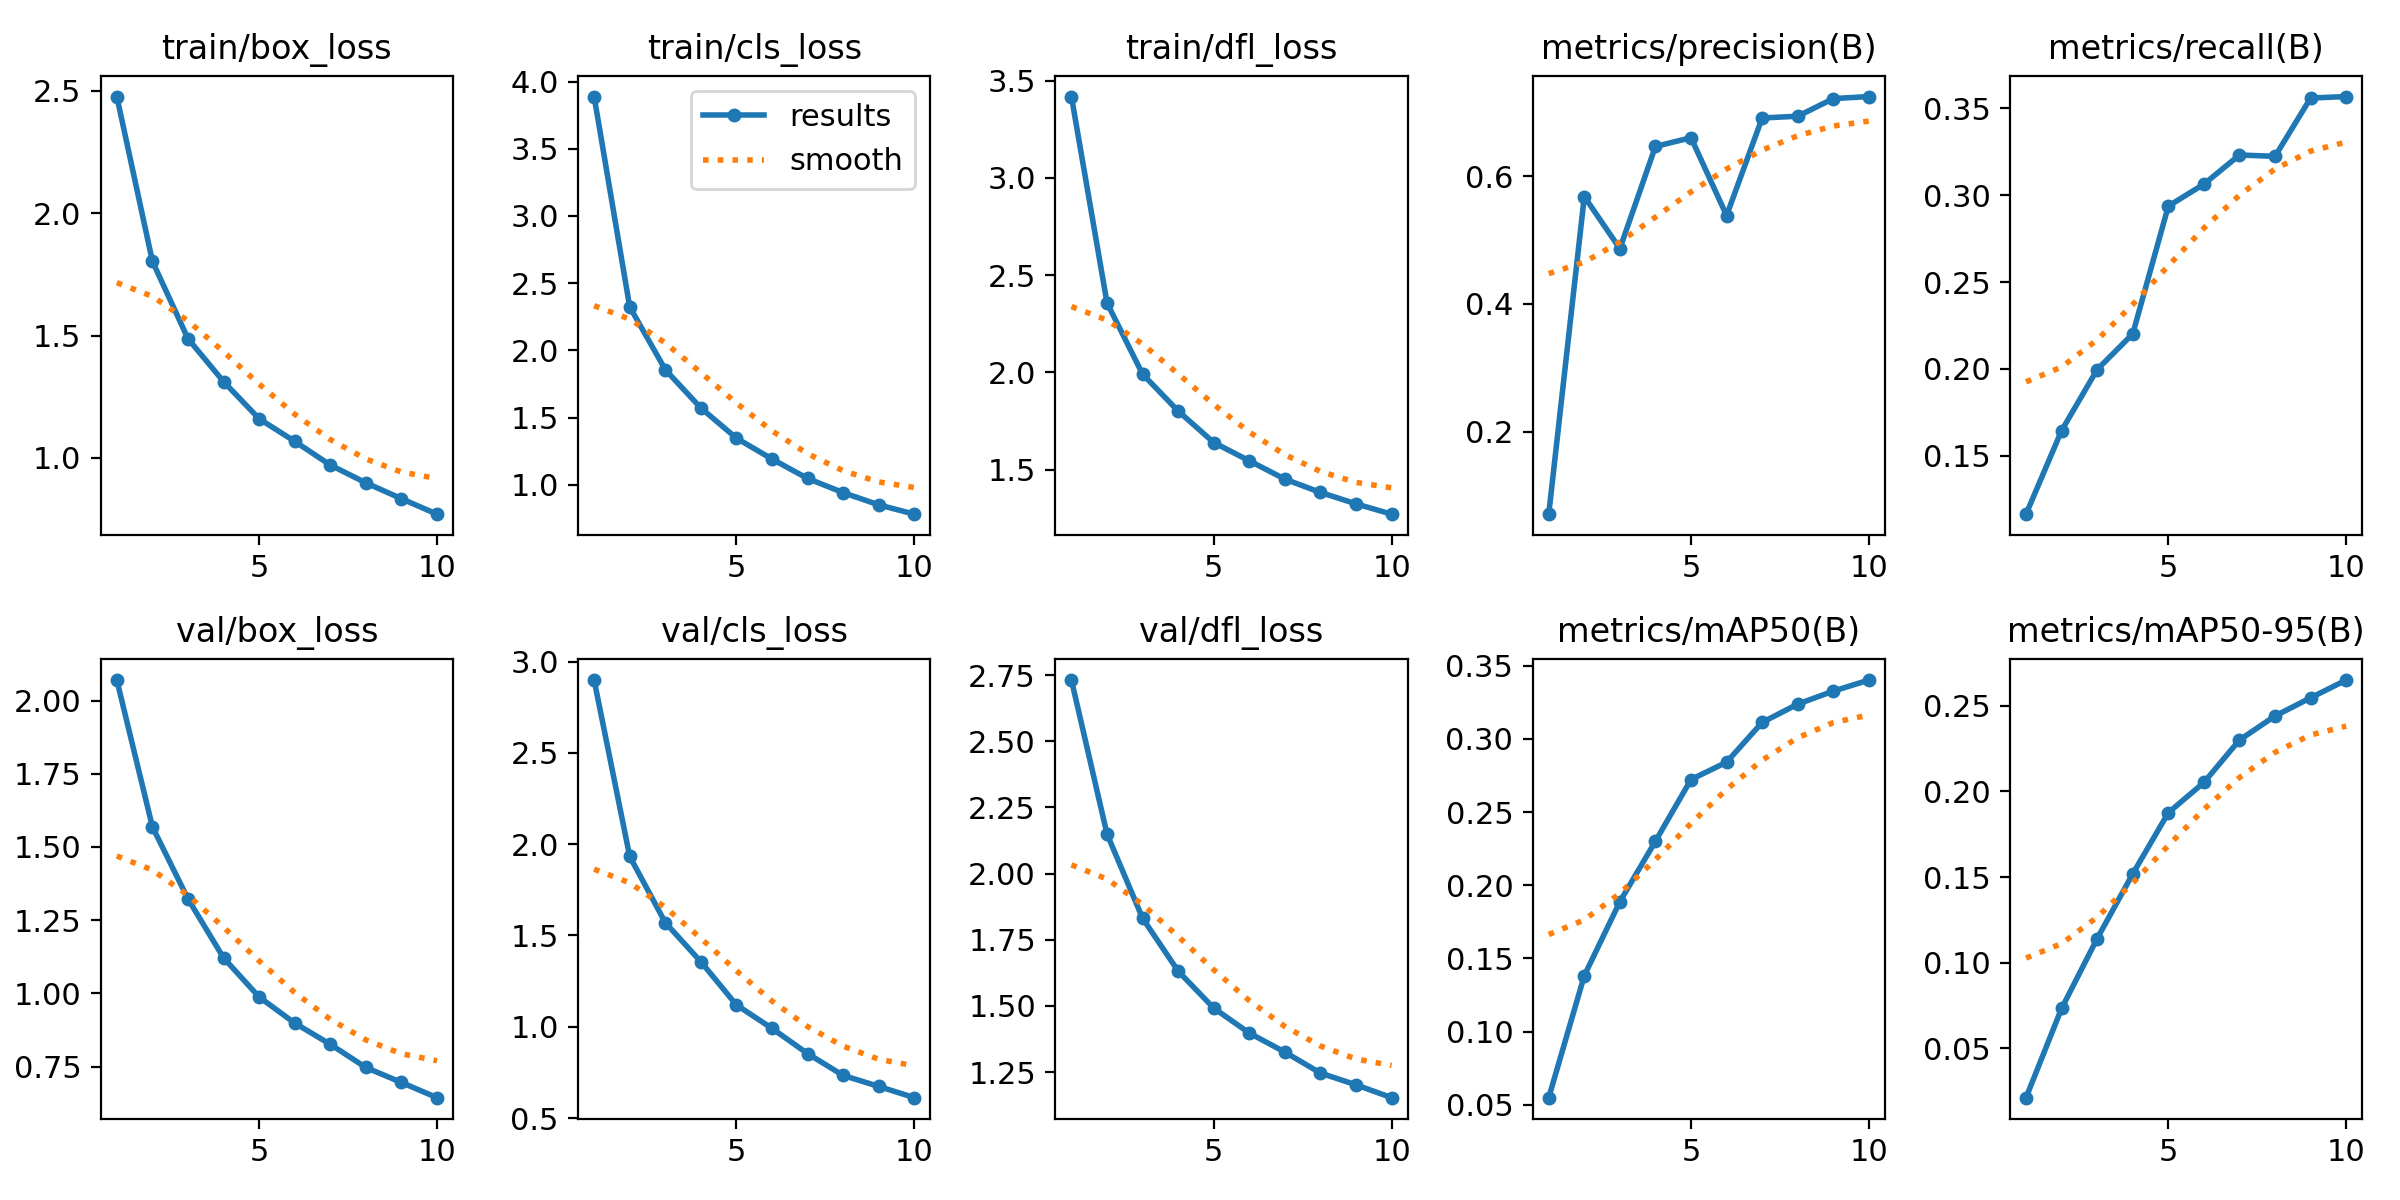

In [32]:
from IPython.display import Image

Image(filename=f'/content/sample_data/train2/results.png', width=1000)

In [33]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Accident', 'NoAcciednt', 'car', 'mild', 'moderate', 'motor cycle', 'severe']

In [34]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/content/sample_data/train2/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [ ]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.4163714694317025
mAP 50 0.8842411767309134
mAP 75 0.33123104776171636


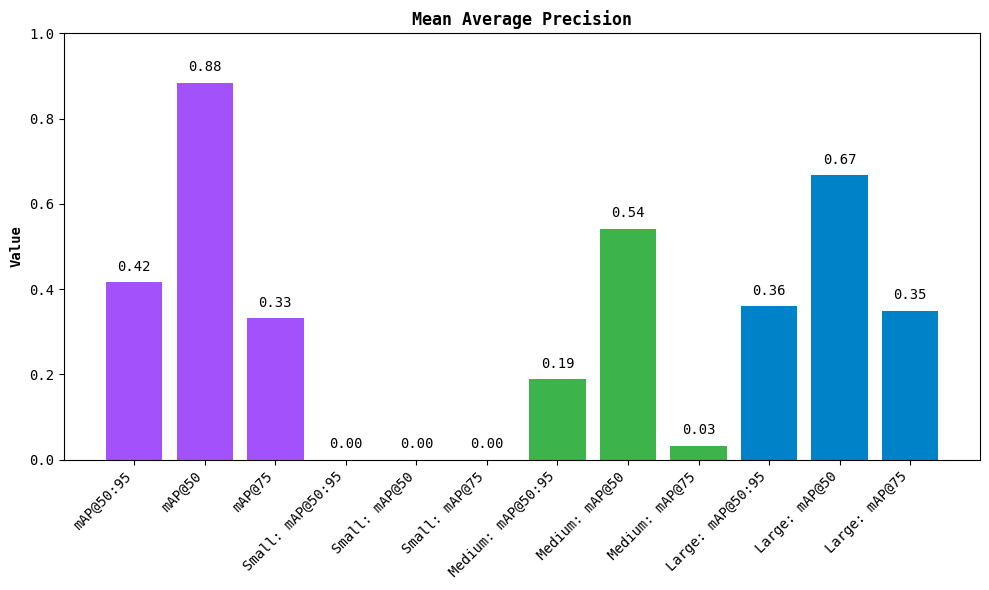

In [ ]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [ ]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

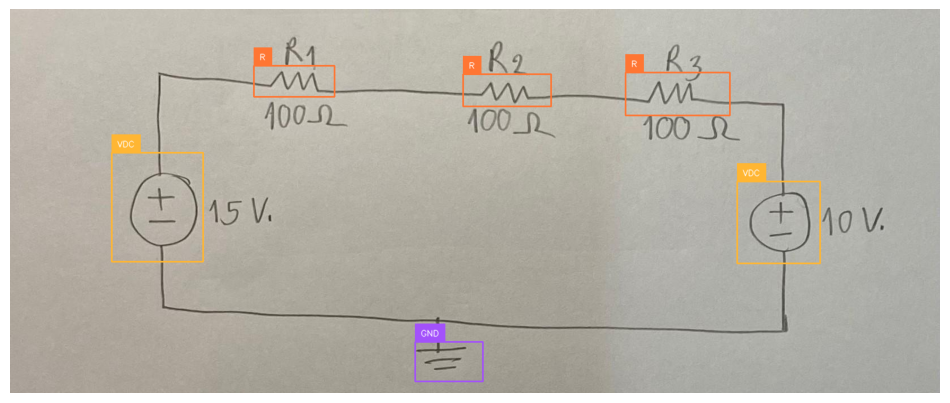

In [ ]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [10]:
!pip install pillow-heif>=0.15.0